##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemma - Translator of Old Korean Literature

The Korean alphabet, or Hangul, has undergone changes over time, resulting in several letters no longer used in modern Korean. These obsolete letters include:

1. ㆍ (Arae-a): This dot vowel represents a short 'a' sound.
2. ㆆ (Yeorin-hieut): Pronounced as a 'light h,' akin to a softer version of the English 'h.'
3. ㅿ (Bansiot): Represents the 'z' sound.
4. ㆁ (Yet-ieung): A velar nasal sound comparable to 'ng' in the word 'sing.'

For Korean speakers, reading older literature presents a challenge due to the utilization of now-obsolete letters. Early Hangul lacked spaces between words, further complicating readability. In contrast, modern Hangul employs spaces, consistent with most alphabetic systems.

However, with the capabilities provided by Gemma, it becomes possible to create a translator that can aid in understanding and bridging the gap between contemporary and archaic Korean.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/Translator_of_Old_Korean_Literature.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environment variables

Set environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Mounting gDrive for to store artifacts
drive.mount("/content/drive")

### Install dependencies

Install Keras and KerasNLP.

In [ ]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 256
lora_name = "translator"
lora_rank = 4
lr_value = 1e-4
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

## Load Dataset

Here's [the dataset](https://huggingface.co/datasets/bebechien/HongGildongJeon) from Hong Gildong jeon (Korean: 홍길동전), which is a Korean novel written during the Joseon Dynasty. The [original source](https://ko.wikisource.org/wiki/%ED%99%8D%EA%B8%B8%EB%8F%99%EC%A0%84_36%EC%9E%A5_%EC%99%84%ED%8C%90%EB%B3%B8) is in public domain. You will use a [modern translation](https://ko.wikisource.org/wiki/%ED%99%8D%EA%B8%B8%EB%8F%99%EC%A0%84_36%EC%9E%A5_%EC%99%84%ED%8C%90%EB%B3%B8/%ED%98%84%EB%8C%80%EC%96%B4_%ED%95%B4%EC%84%9D) in a [creative commons license](https://creativecommons.org/licenses/by-sa/4.0/), translated by `직지프로`.

To simplify the task, you will adopt the following structure for fine-tuning the model. The model will generate contemporary Korean text based on the user's input in Early Hangul.

```
<start_of_turn>user\n
됴션국셰둉ᄃᆡ왕즉위십오연의홍희문밧긔ᄒᆞᆫᄌᆡ상이잇스되
<end_of_turn>\n
<start_of_turn>model\n
조선국 세종대왕 즉위 십오년에 홍회문 밖에 한 재상이 있으되,
```

> NOTE: korean text means, In the fifteenth year of the reign of King Sejong of Joseon, there was a prime minister outside Honghoemun Gate.


In [ ]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

from datasets import load_dataset

ds = load_dataset(
    "bebechien/HongGildongJeon",
    split="train",
)
print(ds)
data = ds.with_format(
    "np", columns=["original", "modern translation"], output_all_columns=False
)
train = []

for x in data:
    item = f"<start_of_turn>user\n{x['original']}<end_of_turn>\n<start_of_turn>model\n{x['modern translation']}<end_of_turn>"
    length = len(tokenizer(item))
    # skip data if the token length is longer than our limit
    if length < token_limit:
        train.append(item)

print(len(train))
print(train[0])
print(train[1])
print(train[2])


Dataset({
    features: ['original', 'modern translation'],
    num_rows: 447
})
302
<start_of_turn>user
됴션국셰둉ᄃᆡ왕즉위십오연의홍희문밧긔ᄒᆞᆫᄌᆡ상이잇스되<end_of_turn>
<start_of_turn>model
조선국 세종대왕 즉위 십오년에 홍회문 밖에 한 재상이 있으되,<end_of_turn>
<start_of_turn>user
셩은홍이요명은문이니위인이쳥염강직ᄒᆞ여덩망이거록ᄒᆞ니당셰의영웅이라<end_of_turn>
<start_of_turn>model
성은 홍이요, 명은 문이니, 위인이 청렴강직하여 덕망이 거룩하니 당세의 영웅이라.<end_of_turn>
<start_of_turn>user
일직용문의올나벼살이할림의쳐ᄒᆞ엿더니명망이됴졍의읏듬되ᄆᆡ젼하그덕망을승이녀긔ᄉᆞ벼살을도도와이조판셔로좌으졍을ᄒᆞ이시니승상이국은을감동ᄒᆞ야갈츙보국ᄒᆞ니ᄉᆞ방의일이업고도젹이업스ᄆᆡ시화연풍ᄒᆞ여나라이ᄐᆡ평ᄒᆞ더라<end_of_turn>
<start_of_turn>model
일찍 용문에 올라 벼슬이 한림에 처하였더니 명망이 조정의 으뜸 되매, 전하 그 덕망을 승히 여기사 벼슬을 돋우어 이조판서로 좌의정을 하게 하시니, 승상이 국은을 감동하여 갈충보국하니 사방에 일이 업고 도적이 없으매 시화연풍하여 나라가 태평하더라.<end_of_turn>


## Load Model

In [ ]:
import keras
import keras_nlp

import time

gemma = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma.summary()

tick_start = 0


def tick():
    global tick_start
    tick_start = time.time()


def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")


def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()


text_gen("ᄃᆡ작ᄒᆞ여그ᄭᅩᆺ치흣터지거ᄂᆞᆯ")
text_gen(
    "금두겁이품의드러뵈니일졍ᄌᆡᄌᆞᄅᆞᆯ나흐리로다ᄒᆞ더니과연그ᄃᆞᆯ부터잉ᄐᆡᄒᆞ여십삭이차니"
)
text_gen(
    "이ᄯᆡᄂᆞᆫᄉᆞ월초팔일이라이날밤의오ᄉᆡᆨ구룸이집을두루고향ᄂᆡ진동ᄒᆞ며션녀ᄒᆞᆫᄡᅣᆼ이촉을들고드러와김ᄉᆡᆼᄃᆞ려니르ᄃᆡ"
)
text_gen("ᄌᆡ히길너텬졍을어긔지말으소셔이아희ᄇᆡ필은낙양니샹셔집아ᄌᆡ니")

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
ᄃᆡ작ᄒᆞ여그ᄭᅩᆺ치흣터지거ᄂᆞᆯ<end_of_turn>
<start_of_turn>model
It looks like you've entered some Korean text.  

Unfortunately, I can't understand the meaning of this text.  

**Here's why:**

* **Korean characters:**  The characters you entered are Korean, but without context, I can't decipher their meaning. 
* **Possible typos:** It's possible there are typos in the text. 

**To help me understand, please provide:**

* **The context:** Where did you find this text? What was the situation?
* **The intended meaning:** Do you know what you're trying to say? 
* **The intended language:** Are you sure it's Korean?


Let me know, and I'll do my best to help! 
<end_of_turn>
TOTAL TIME ELAPSED: 25.60s

Gemma output:
<start_of_turn>user
금두겁이품의드러뵈니일졍ᄌᆡᄌᆞᄅᆞᆯ나흐리로다ᄒᆞ더니과연그ᄃᆞᆯ부터잉ᄐᆡᄒᆞ여십삭이차니<end_of_turn>
<start_of_turn>model
This appears to be a Korean sentence written in a very archaic style.  It's difficult to understand without more context. 

Here's why it's challenging a

## LoRA Fine-tuning

In [ ]:
# Enable LoRA for the model and set the LoRA rank (4, 8 or 16).
gemma.backbone.enable_lora(rank=lora_rank)
gemma.summary()

# Limit the input sequence length (to control memory usage).
gemma.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

## Save LoRA for each epoch

Epoch 1/5
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - loss: 2.6158 - sparse_categorical_accuracy: 0.3294
Gemma output:
<start_of_turn>user
ᄃᆡ작ᄒᆞ여그ᄭᅩᆺ치흣터지거ᄂᆞᆯ<end_of_turn>
<start_of_turn>model
다작하여 그 토성치허지거나라<end_of_turn>
TOTAL TIME ELAPSED: 16.91s

Gemma output:
<start_of_turn>user
금두겁이품의드러뵈니일졍ᄌᆡᄌᆞᄅᆞᆯ나흐리로다ᄒᆞ더니과연그ᄃᆞᆯ부터잉ᄐᆡᄒᆞ여십삭이차니<end_of_turn>
<start_of_turn>model
금두거이품에 드러뵈니 일정자자를 나히로다하여 더니 과연 그 대부터 이태하여십삭이 차니<end_of_turn>
TOTAL TIME ELAPSED: 2.78s

Gemma output:
<start_of_turn>user
이ᄯᆡᄂᆞᆫᄉᆞ월초팔일이라이날밤의오ᄉᆡᆨ구룸이집을두루고향ᄂᆡ진동ᄒᆞ며션녀ᄒᆞᆫᄡᅣᆼ이촉을들고드러와김ᄉᆡᆼᄃᆞ려니르ᄃᆡ<end_of_turn>
<start_of_turn>model
이태남사월초팔일이라날밤에오사극구름이집을두루고향내진동하며션녀한백이촉을들고드러와김사장대려니르다<end_of_turn>
TOTAL TIME ELAPSED: 3.73s

Gemma output:
<start_of_turn>user
ᄌᆡ히길너텬졍을어긔지말으소셔이아희ᄇᆡ필은낙양니샹셔집아ᄌᆡ니<end_of_turn>
<start_of_turn>model
죄송하지만, 
<end_of_turn>
TOTAL TIME ELAPSED: 0.93s
302/302 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - loss: 2.6141 - sparse_categorical_accuracy: 0.3296 
Epoch 2/5
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - loss: 1.6853 - sparse

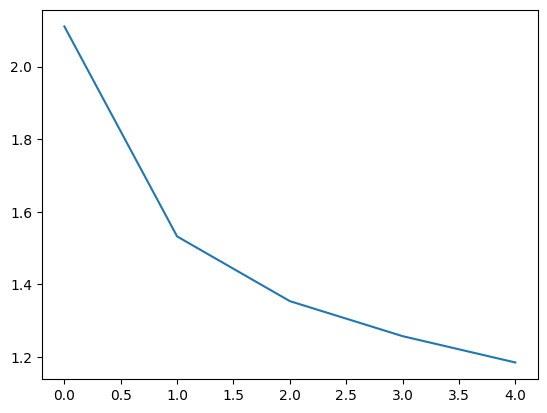

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("ᄃᆡ작ᄒᆞ여그ᄭᅩᆺ치흣터지거ᄂᆞᆯ")
    text_gen(
      "금두겁이품의드러뵈니일졍ᄌᆡᄌᆞᄅᆞᆯ나흐리로다ᄒᆞ더니과연그ᄃᆞᆯ부터잉ᄐᆡᄒᆞ여십삭이차니"
    )
    text_gen(
      "이ᄯᆡᄂᆞᆫᄉᆞ월초팔일이라이날밤의오ᄉᆡᆨ구룸이집을두루고향ᄂᆡ진동ᄒᆞ며션녀ᄒᆞᆫᄡᅣᆼ이촉을들고드러와김ᄉᆡᆼᄃᆞ려니르ᄃᆡ"
    )
    text_gen("ᄌᆡ히길너텬졍을어긔지말으소셔이아희ᄇᆡ필은낙양니샹셔집아ᄌᆡ니")

history = gemma.fit(train, epochs=train_epoch, batch_size=1, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()


## Expansion Idea

To achieve similar tasks, you can replicate the same structure. Below are some examples:

* American English <-> British English datasets

Various everyday objects and concepts have different names depending on the region. For example, in American English (AmE), people use terms like "elevator," "truck," "cookie," and "french fries," while in British English (BrE), the equivalent words are "lift," "lorry," "biscuit," and "chips," respectively.

Apart from vocabulary differences, spelling variations also exist. For instance, in AmE, words ending in "-or" are often spelled with "-our" in BrE. Examples include "color" (AmE) and "colour" (BrE), or "humor" (AmE) and "humour" (BrE).

Another spelling variation is the "-ize" versus "-ise" distinction. In AmE, words like "organize" and "realize" are commonly spelled with a "z," whereas in BrE, the preferred spelling is "organise" and "realise," using an "s" instead.

With the help of AI tools like Gemma, it is possible to create a style transfer from one English dialect to another, allowing seamless transitions between American and British English writing styles.

* Kansai-ben datasets

In the Kansai region of Japan, there is a distinct group of dialects known as Kansai-ben. Compared to the standard Japanese language, Japanese speakers perceive Kansai-ben as being both more melodic and harsher in its pronunciation and intonation.

Utilizing the capabilities of Gemma, you can create a dialect translator by preparing a substantial quantity of Kansai-ben datasets.
